In [1]:
import pandas as pd

In [4]:
from pathlib import Path
import sequence_sensei
import numpy as np

In [3]:
import axelrod as axl

In [5]:
axl.__version__

'4.2.0'

In [59]:
dfs = []
for file in Path("raw_data/").glob("*.csv"):
    dfs.append(pd.read_csv(file, index_col=0,))

In [60]:
df = pd.concat(dfs).reset_index(drop=True)

In [61]:
df.head()

,index,opponent,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,...,gene_195,gene_196,gene_197,gene_198,gene_199,gene_200,gene_201,gene_202,gene_203,gene_204
0,104658,PSO Gambler 2_2_2,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,125559,Getzler,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,0,0
2,103232,Stochastic WSLS,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,103233,Stochastic WSLS,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,103234,Stochastic WSLS,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [62]:
df = df[~(df['opponent'].str.contains('Majority'))]

In [69]:
df.to_csv('targets.csv')

In [52]:
len(df)

3688

In [28]:
import axelrod as axl

In [29]:
strategies = {strategy().name: strategy() for strategy in axl.all_strategies}

In [54]:
opponents_moves = []
for opponent in df['opponent']:
    
    opponent = strategies[opponent.split(':')[0]]
    
    sequence = sequence_sensei.get_sequence_str(df.iloc[0].values[-205:])
    cycler = axl.Cycler(sequence)

    match = axl.Match([opponent, cycler], turns=205)
    _ = match.play()
    
    moves_opp, moves_cycler = zip(*match.result)
    
    assert sequence_sensei.get_sequence_str(moves_cycler) == sequence
    
    opponents_moves.append(moves_opp)

In [55]:
len(opponents_moves)

3688

**Transform Data for RNN**

In [56]:
sequences = [[move.value for move in moves] for moves in opponents_moves]

In [57]:
data = pd.DataFrame(sequences)

In [58]:
data.to_csv('sequences.csv')

In [10]:
def prepare_sequence_format(row):

    data = np.zeros(shape=(len(row), len(row)))
    values = []

    for i, value in enumerate(row):
        if value == 1:
            values.append(value)
        else:
            values.append(-1)
        for j, item in enumerate(values):
            data[i, j] = item
            
    return data

In [18]:
data = np.array([prepare_sequence_format(row) for row in sequences])

In [19]:
validation = np.array([[1 if value == 1 else -1 for value in row] for row in sequences])

In [20]:
validation.shape

(5, 205)

In [21]:
data = np.array([np.reshape(row, (row.shape[0], 1, row.shape[1])) for row in data])

In [22]:
data.shape[2:]

(1, 205)

In [23]:
# data = np.reshape(data, (data.shape[0], 1, data.shape[1]))
# validation = np.reshape(validation, (validation.shape[0], 1, validation.shape[1]))

**First Fitting to the model**

In [24]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten

Using TensorFlow backend.


In [27]:
model =  Sequential()
model.add(LSTM(205, input_shape=data.shape[2:]))

model.add(Dense(205))

Instructions for updating:
Colocations handled automatically by placer.


In [28]:
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

In [29]:
model.fit(data[0], validation[0], epochs=10, batch_size=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
205/205 [==============================] - 4s 18ms/step - loss: 0.2276 - acc: 0.9854
Epoch 2/10
205/205 [==============================] - 3s 14ms/step - loss: 2.2584e-04 - acc: 1.0000
Epoch 3/10
205/205 [==============================] - 3s 14ms/step - loss: 5.7764e-05 - acc: 1.0000
Epoch 4/10
205/205 [==============================] - 3s 14ms/step - loss: 0.0021 - acc: 1.0000
Epoch 5/10
205/205 [==============================] - 3s 17ms/step - loss: 0.0013 - acc: 1.0000
Epoch 6/10
205/205 [==============================] - 3s 14ms/step - loss: 2.4640e-05 - acc: 1.0000
Epoch 7/10
205/205 [==============================] - 3s 16ms/step - loss: 2.4639e-05 - acc: 1.0000
Epoch 8/10
205/205 [==============================] - 3s 14ms/step - loss: 2.4636e-05 - acc: 1.0000
Epoch 9/10
205/205 [==============================] - 2s 12ms/step - loss: 2.4631e-05 - acc: 1.0000
Epoch 10/10
205/205 [==============================] - 2s 11ms/s

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 205)               337020    
_________________________________________________________________
dense_1 (Dense)              (None, 205)               42230     
Total params: 379,250
Trainable params: 379,250
Non-trainable params: 0
_________________________________________________________________


In [31]:
from keras.utils.vis_utils import plot_model

In [32]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [37]:
history = model.fit(data[0], validation[0], epochs=10, batch_size=1)

Epoch 1/10
205/205 [==============================] - 3s 14ms/step - loss: 2.4625e-05 - acc: 1.0000
Epoch 2/10
205/205 [==============================] - 3s 14ms/step - loss: 2.4622e-05 - acc: 1.0000
Epoch 3/10
205/205 [==============================] - 3s 14ms/step - loss: 2.4617e-05 - acc: 1.0000
Epoch 4/10
205/205 [==============================] - 3s 16ms/step - loss: 2.4611e-05 - acc: 1.0000
Epoch 5/10
205/205 [==============================] - 3s 14ms/step - loss: 2.4605e-05 - acc: 1.0000
Epoch 6/10
205/205 [==============================] - 3s 15ms/step - loss: 2.4601e-05 - acc: 1.0000
Epoch 7/10
205/205 [==============================] - 3s 16ms/step - loss: 2.4595e-05 - acc: 1.0000
Epoch 8/10
205/205 [==============================] - 4s 19ms/step - loss: 2.4585e-05 - acc: 1.0000
Epoch 9/10
205/205 [==============================] - 3s 15ms/step - loss: 2.4578e-05 - acc: 1.0000
Epoch 10/10
205/205 [==============================] - 4s 17ms/step - loss: 2.4566e-05 - acc: 1.0000

In [38]:
import matplotlib.pyplot as plt

In [40]:
history.history

{'acc': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'loss': [2.462528656640022e-05,
  2.4621797735851098e-05,
  2.4616564600941408e-05,
  2.4611331483777952e-05,
  2.4604935437886657e-05,
  2.460086530268976e-05,
  2.459505057919248e-05,
  2.458458435373869e-05,
  2.457760698545338e-05,
  2.456597773366744e-05]}

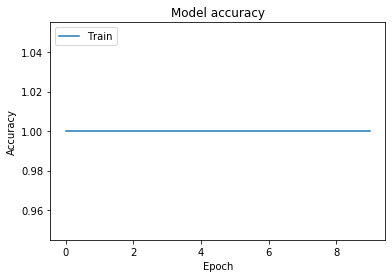

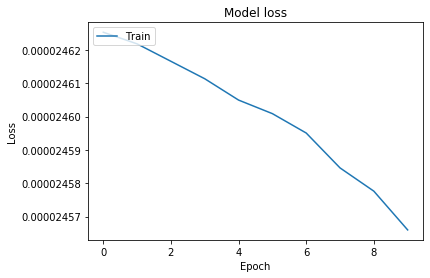

In [41]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

**Multiple Data**